# Prüfungsleistung Data Science

- Matthias Hagg 
- 4392350 
- T-INF19E

---

# Themengebiet

ARMA Modell zum Klimawandel

---

## Imports

In [1]:
#Imports aller benötigten Biblioteken
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import numpy as np
import pandas as pd
import statistics
import copy
import statsmodels.api as sm
from datetime import datetime
from matplotlib.pyplot import figure
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression

#Einlesen und speichern der Datensets. 
#Die Variable "daten_groß" beinhaltet das Datenset zu den täglichen Wetterdaten von 1985 bis 2021. (13473 Datensätze)
#Die Variable "daten_klein" beinhaltet das Datenset zu den täglichen Wetterdaten von 2019 bis 2020. (731 Datensätze)
daten_groß = pd.read_csv("Daten/climatechange_basel.csv", sep = ';')           # 1985 bis 2021
daten_klein = pd.read_csv("Daten/climatechange_basel_2_Jahre.csv", sep = ';')  # 2019 bis 2020

sns.set()

---

## Task 1

### Performa an EDA and plot the data. What can you see now?

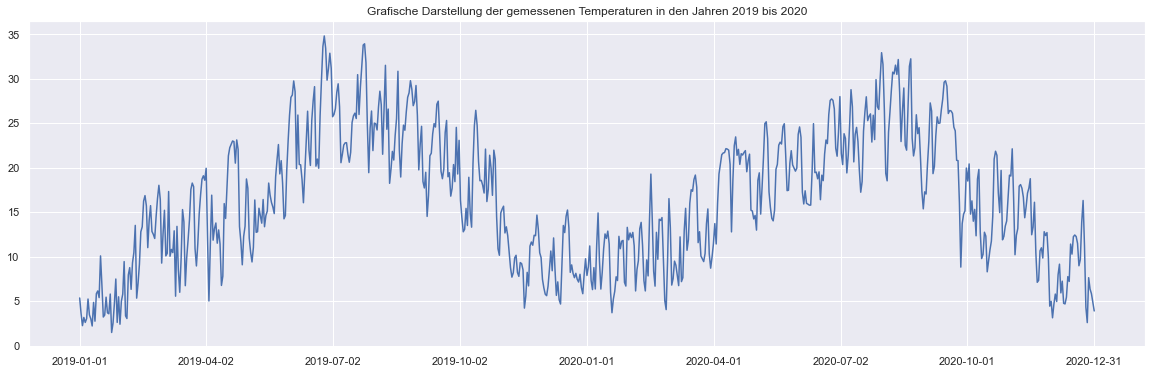

In [2]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen.
daten_lokal_1=copy.deepcopy(daten_klein)

#Timestamp besteht in Grunddaten aus Datum und Uhrzeit. Da Nur das Datum benötigt wird, wird der Timestamp entsprechend zugeschnitten.
daten_lokal_1["timestamp"]=daten_lokal_1["timestamp"].str[0:10]

#Erstellen der Grafik:
#Festlegen der Größe, Titel und Schrittweite
#Darstellung: Gemessene Temperaturen (täglich) von 2019 bis 2020
plt.figure(figsize=(20, 6))
plt.plot(daten_lokal_1["timestamp"], daten_lokal_1["Basel Temperature [2 m elevation corrected]"])
plt.xticks(np.arange(0, 731, step=91.25))
plt.title("Grafische Darstellung der gemessenen Temperaturen in den Jahren 2019 bis 2020")
plt.show()

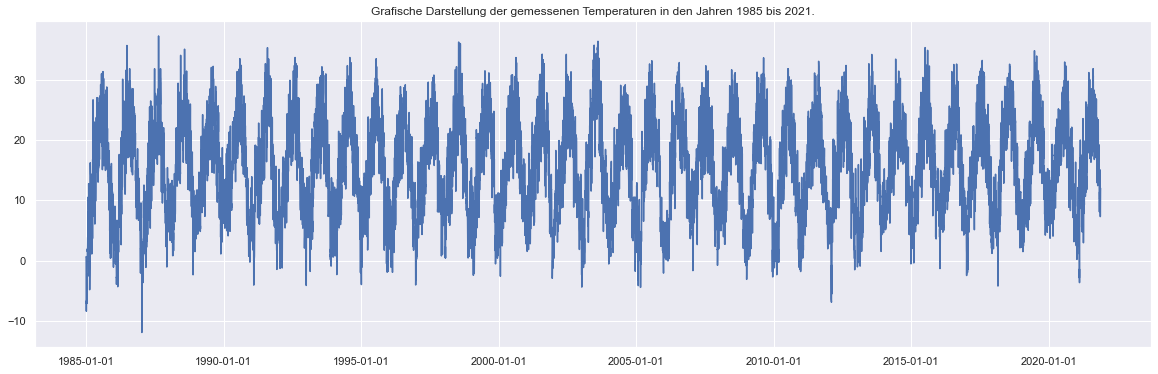

In [3]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen.
daten_lokal_2=copy.deepcopy(daten_groß)

#Timestamp besteht in Grunddaten aus Datum und Uhrzeit. Da Nur das Datum benötigt wird, wird der Timestamp entsprechend zugeschnitten.
daten_lokal_2["timestamp"]=daten_lokal_2["timestamp"].str[0:10]

#Erstellen der Grafik:
#Festlegen der Größe, Titel und Schrittweite
#Darstellung: Gemessene Temperaturen (täglich) von 1985 bis 2021
plt.figure(figsize=(20, 6))
plt.plot(daten_lokal_2["timestamp"], daten_lokal_2["Basel Temperature [2 m elevation corrected]"])
plt.xticks(np.arange(0, 13473, step=1826.15))
plt.title("Grafische Darstellung der gemessenen Temperaturen in den Jahren 1985 bis 2021.")
plt.show()

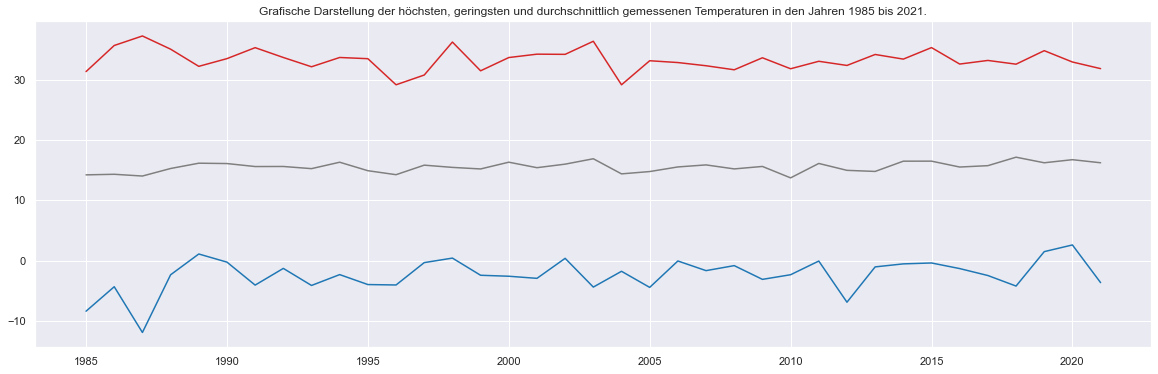

In [4]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen.
daten_lokal_3=copy.deepcopy(daten_groß)

#Timestamp besteht in Grunddaten aus Datum und Uhrzeit. Da Nur das Datum benötigt wird, wird der Timestamp entsprechend zugeschnitten.
daten_lokal_3["timestamp"]=daten_lokal_3["timestamp"].str[0:4]

#Startjahr für die Schleife. Soll das kleine Datenset verwendet werden, muss das Startjahr auf 2019 gesetzt werden.
startjahr=1985

#Anlegen der für die Berechnung benötigten Listen
jahre=[]
temp_min=[]
temp_max=[]
temp_schnitt=[]

#Temperaturdaten anhand der Jahre gruppieren
jahresgruppen = daten_lokal_3.groupby(["timestamp"])

#Schleife um alle Jahresgruppen zu durchlaufen. Soll das kleine Datenset verwendet werden, muss die Abbruchbedingung auf 2020 gesetzt werden.
while startjahr <= 2021:
    
    #Erhalte alle Daten aus dem aktuellen Jahr
    gruppendatensatz=jahresgruppen.get_group(str(startjahr))
    
    #Daten in zuvor angelegte Listen speichern. Gespeichert werden Jahr, höchst-, geringste- und niedrigste Temperatur
    jahre.append(startjahr)
    temp_min.append(min((gruppendatensatz["Basel Temperature [2 m elevation corrected]"])))
    temp_max.append(max((gruppendatensatz["Basel Temperature [2 m elevation corrected]"])))
    temp_schnitt.append(statistics.mean(gruppendatensatz["Basel Temperature [2 m elevation corrected]"]))
    
    #Erhöhung des nächsten Jahres für den nächsten Schleifendurchlauf
    startjahr=startjahr+1

#Erstellen der Grafik:
#Festlegen der Größe, Titel und Schrittweite
#Darstellung: Höchsten (rot), geringsten (blau) und durchschnittlich (grau) gemessenen Temperaturen in den Jahren 1985 bis 2021.
plt.figure(figsize=(20, 6))
plt.title("Grafische Darstellung der höchsten, geringsten und durchschnittlich gemessenen Temperaturen in den Jahren 1985 bis 2021.")
plt.plot(jahre, temp_min, color = 'tab:blue')
plt.plot(jahre, temp_max, color = 'tab:red')
plt.plot(jahre, temp_schnitt, color = 'tab:grey')
plt.show()

Aus den drei oben dargestellten Temperaturdaten as Basel lassen sich folgende Aussagen treffen:
- Basel hatte in den Jahren 2019 und 2020 im Tagesschnitt keine Temperaturen unter 0°C.
- Die kältesten Temperaturen in den Jahren 1985 bis 2021 steigen tendenziell leicht an.
- Die Temperatur im Jahresmittel steigt tendenziell im Zeitraum von 1985 bis 2021 an.

---

## Task 2

### Is Temperature a Random Walk (with Drift)?

An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.
Plot the data and test whether it follows a random walk (with drift).

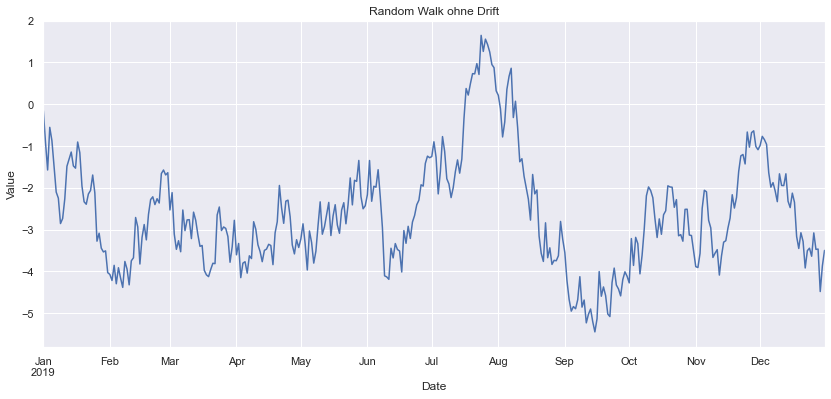

In [5]:
#Beispiel eines Random Walk
#Bei Random Walk stehen die Folgewerte immer in Verbindung mit den zuvor festgelegten Werten.
mean = 0
sigma = 0.5
n_pts = 365

#Erzeuge Daten und Zufallszahlen
dates = pd.date_range(start='1/1/2019', periods=n_pts)
epsilon = np.random.normal(mean,sigma,n_pts)

#Erzeuge Daten, welche bei auf den voerhergegangenen Wert addiert werden
y0 = 0
vals = y0 + np.cumsum(epsilon) 
time_series =  pd.Series(vals, index=dates)

#Erstellen der Grafik Random Walk ohne Drift
plt.title("Random Walk ohne Drift")
ax = time_series.plot(figsize=(14,6))
ax.set_ylabel("Value")
ax.set_xlabel("Date")
plt.show()

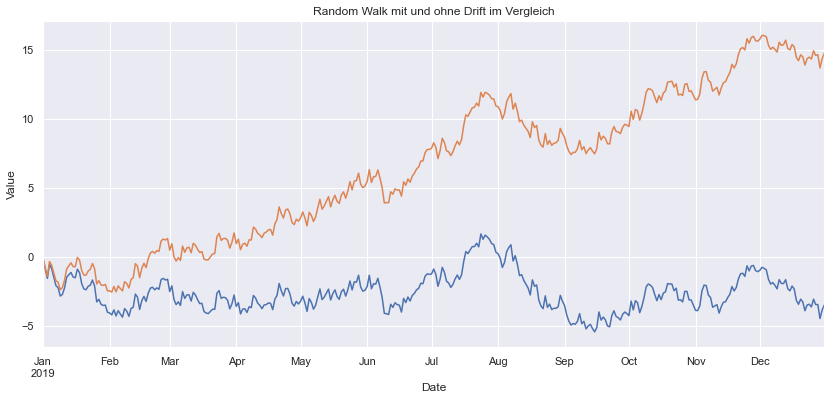

In [6]:
#Beispiel eines Random Walk mit Drift (auf Basis von Werten aus vorherigem Code-Beispiel)
#Bei Random Walk stehen die Folgewerte immer in Verbindung mit den zuvor festgelegten Werten, werden jedoch durch eine definierte
#Konstante beinflusst
drift = 0.05
drift_werte = y0 + np.cumsum(epsilon + drift) 
time_drift =  pd.Series(drift_werte, index=dates)

#Erstellen der Grafik
#Blaue Linie stellt den Random Walk ohne Drift dar
#Orangene Linie stellt den Random Walk mit Drift dar
plt.title("Random Walk mit und ohne Drift im Vergleich")
ax = time_series.plot(figsize=(14,6))
time_drift.plot()
ax.set_ylabel("Value")
ax.set_xlabel("Date")
plt.show()

Entsprechend der Definition und der beiden Beispiele von Random Walk und Random Walk mit Drift lassen sich folgende Aussagen treffen:
- Temperaturverläufe sind ein Random Walk
    - Temperaturverläufe entstehen nicht zufällig. Die Temperatur an Tag y1 ist nicht vollständig unabhängig von der Temperatur a Tag y0, dennoch können die Werte zufällig steigen bzw. sinken.
- Temperaturverläufe haben einen Drift
    - Temperaturverläufe besitzen zwei Arten von Drift. 
        - Auf kürzere Laufzeit sind sie der Jahreszeit und damit saisonalen Verläufen unterworfen. Somit entsteht hier ein Sommer/Winter-Drift.
        - Auf Längere Sicht gibt es einen Anstieg der durchschnittlichen Jahrestemperatur (siehe Task 1), welcher ebenfalle einen leichten Drift in höhere Werte darstellt.

---

## Task 3

### Look at Autocorrelations

If the temperature series is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

In [7]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen. Zusätzlich reduzieren auf Zeitstempel und Temperaturen.
daten_lokal_4 = copy.deepcopy(daten_groß)
temperaturen = daten_lokal_4[["timestamp", "Basel Temperature [2 m elevation corrected]"]]

#Prüfung ob die Daten stationär sind
X=temperaturen["Basel Temperature [2 m elevation corrected]"].values
result=adfuller(X)
print('ADF Static: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]['5%']:
    print('Die Daten sind Stationär')
else:
    print('Die Daten sind nicht Stationär')

ADF Static: -8.157474
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Die Daten sind Stationär


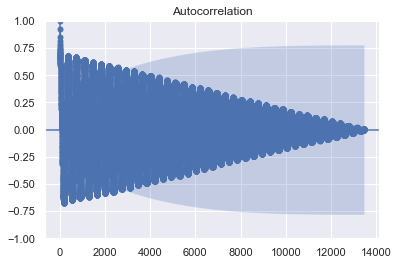

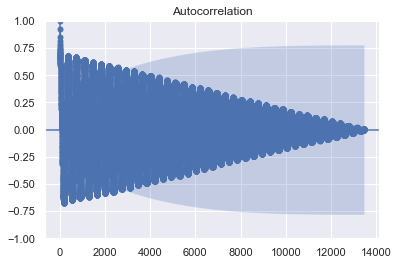

In [8]:
#Plot ACF der Daten
plot_acf(X, lags=13470)

c:\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


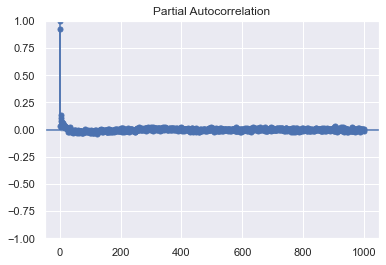

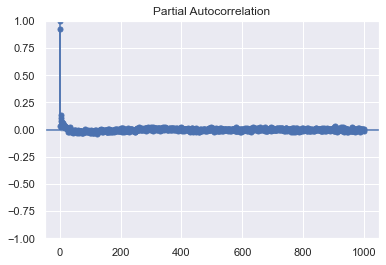

In [9]:
#Plot PACF der Daten
plot_pacf(X, lags=1000)

In [10]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen. Zusätzlich reduzieren auf Temperaturen.
daten_lokal_5 = copy.deepcopy(daten_groß)
series = daten_lokal_5["Basel Temperature [2 m elevation corrected]"]

#Temperaturdaten in values speichern und shiften
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)

#Berechnung der Korrelation und ausgabe
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.921946
t+1  0.921946  1.000000


- Bei diesen Temperaturdaten liegt eine stark positive Korrelation vor.
    - Die Korrelation liegt mit rund 0.9 sehr nahe der 1. Dies sagt aus, dass die einzelnen Temperaturdaten eine hohe gegenseitige Beziehung zueinander haben. Eine postitive Korrelation bedeutet, das die Werte über eine längeren Bereich ansteigen.

---

## Task 4

### Which ARMA Model is Best?

Recall from theory that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

In [11]:
#Die Temperaturdaten werden für das Jahr 2020 auf Basis der Jahre 1985 bis 2019 vorhergesagt

In [12]:
#AR mit einfachem Shift
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen. Zusätzlich reduzieren auf Zeitstempel und Temperaturen.
daten_lokal_6 = copy.deepcopy(daten_groß)
temperaturen = daten_lokal_6[["timestamp", "Basel Temperature [2 m elevation corrected]"]]

#Daten für extraktion der Jaheszahl "duplizieren" und Timestamp auf erste 4 Stellen (Jahreszahl) zuschneiden
daten_lokal_6_year=daten_lokal_6
daten_lokal_6_year["timestamp"]=daten_lokal_6["timestamp"].str[0:4]

#Temperaturwerte in X speichert und shiften
X=temperaturen["Basel Temperature [2 m elevation corrected]"].values
temperaturen["Temperaturen verschoben"] = temperaturen["Basel Temperature [2 m elevation corrected]"].shift()

#Nicht benötigte Datensätze (Spalte Timestamp und NaN-Werte) löschen
temperaturen.drop('timestamp', axis=1, inplace=True)
temperaturen.dropna(inplace=True)

#Ursprüngliche und geshiftete Daten zuweisen
y = temperaturen["Basel Temperature [2 m elevation corrected]"].values
X = temperaturen["Temperaturen verschoben"].values

C:\Users\matth\AppData\Local\Temp/ipykernel_10012/3465862326.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperaturen["Temperaturen verschoben"] = temperaturen["Basel Temperature [2 m elevation corrected]"].shift()
c:\python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

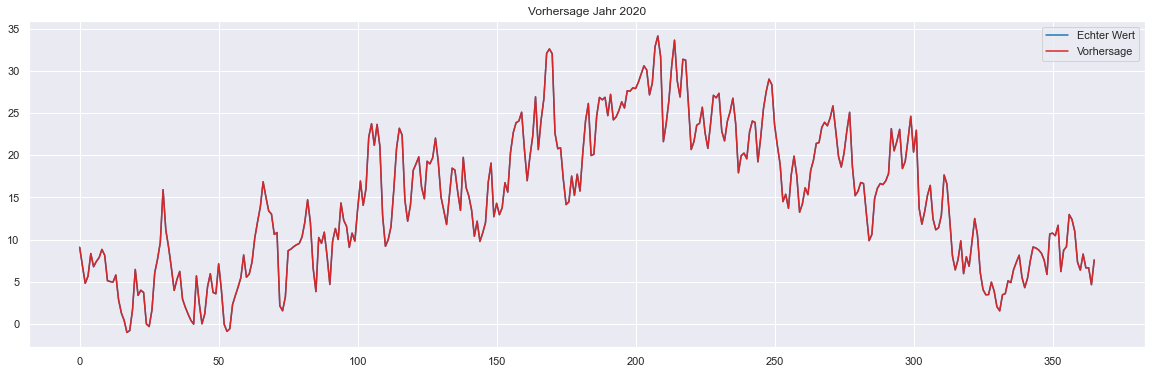

In [13]:
#Werte für vorraussage festlegen
jahr_der_vorhersage = len(daten_lokal_6_year.groupby(["timestamp"]).get_group(str(2020)))
ausblenden_2021 = len(daten_lokal_6_year.groupby(["timestamp"]).get_group(str(2021)))
jahre_gesamt = len(daten_lokal_6)
training_groesse = int((jahre_gesamt-jahr_der_vorhersage-ausblenden_2021)*0.8)

#Trainings- und Testdaten setzen
x_train, x_test = X[0:training_groesse], X[training_groesse:training_groesse+jahr_der_vorhersage]
y_train, y_test = X[0:training_groesse], X[training_groesse:training_groesse+jahr_der_vorhersage]

#Reshape der Daten
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

#Vorhersage erstellen
lr = LinearRegression()
lr.fit(x_train, y_train)
vorhersage = lr.predict(x_test)

#Erstellen der Grafik
plt.figure(figsize=(20, 6))
plt.title("Vorhersage Jahr 2020")
plt.plot(y_test[0:], label="Echter Wert", color = 'tab:blue')
plt.plot(vorhersage[0:], label="Vorhersage", color = 'tab:red')
plt.legend()
plt.show()

In [14]:
#AR mit zweifachem Shift
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen. Zusätzlich reduzieren auf Zeitstempel und Temperaturen.
daten_lokal_7 = copy.deepcopy(daten_groß)
temperaturen = daten_lokal_7[["timestamp", "Basel Temperature [2 m elevation corrected]"]]

#Daten für extraktion der Jaheszahl "duplizieren" und Timestamp auf erste 4 Stellen (Jahreszahl) zuschneiden
daten_lokal_7_year=daten_lokal_7
daten_lokal_7_year["timestamp"]=daten_lokal_7["timestamp"].str[0:4]

#Temperaturwerte in X speichert und 2 Mal shiften
X=temperaturen["Basel Temperature [2 m elevation corrected]"].values
temperaturen["Temperaturen verschoben"] = temperaturen["Basel Temperature [2 m elevation corrected]"].shift()
temperaturen["Temperaturen verschoben x2"] = temperaturen["Temperaturen verschoben"].shift()

#Nicht benötigte Datensätze (Spalte Timestamp und NaN-Werte) löschen
temperaturen.drop('timestamp', axis=1, inplace=True)
temperaturen.drop('Temperaturen verschoben', axis=1, inplace=True)
temperaturen.dropna(inplace=True)

#Ursprüngliche und geshiftete Daten zuweisen
y = temperaturen["Basel Temperature [2 m elevation corrected]"].values
x = temperaturen["Temperaturen verschoben x2"].values

C:\Users\matth\AppData\Local\Temp/ipykernel_10012/3347330185.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperaturen["Temperaturen verschoben"] = temperaturen["Basel Temperature [2 m elevation corrected]"].shift()
C:\Users\matth\AppData\Local\Temp/ipykernel_10012/3347330185.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperaturen["Temperaturen verschoben x2"] = temperaturen["Temperaturen verschoben"].shift()
c:\python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 

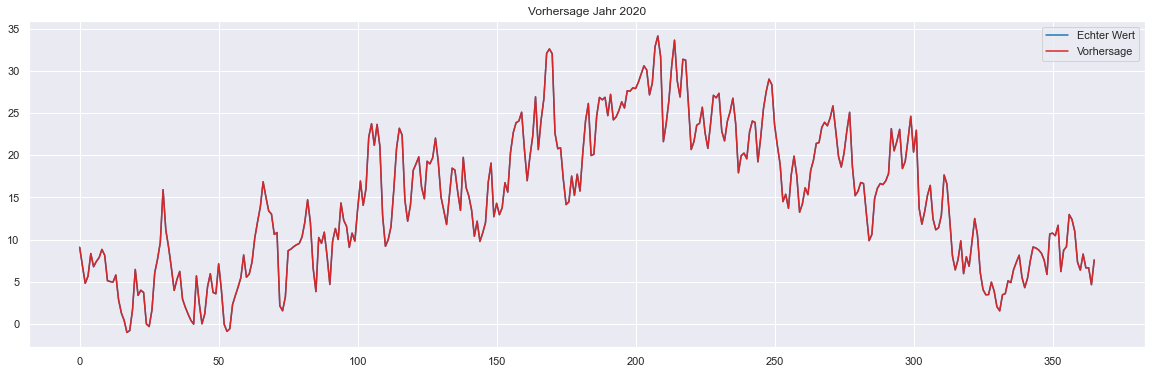

In [15]:
#Werte für vorraussage festlegen
jahr_der_vorhersage = len(daten_lokal_7_year.groupby(["timestamp"]).get_group(str(2020)))
ausblenden_2021 = len(daten_lokal_7_year.groupby(["timestamp"]).get_group(str(2021)))
jahre_gesamt = len(daten_lokal_7)
training_groesse = int((jahre_gesamt-jahr_der_vorhersage-ausblenden_2021)*0.8)

#Trainings- und Testdaten setzen
x_train, x_test = X[0:training_groesse], X[training_groesse:training_groesse+jahr_der_vorhersage]
y_train, y_test = X[0:training_groesse], X[training_groesse:training_groesse+jahr_der_vorhersage]

#Reshape der Daten
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

#Vorhersage erstellen
lr = LinearRegression()
lr.fit(x_train, y_train)
vorhersage = lr.predict(x_test)

#Erstellen der Grafik
plt.figure(figsize=(20, 6))
plt.title("Vorhersage Jahr 2020")
plt.plot(y_test[0:], label="Echter Wert", color = 'tab:blue')
plt.plot(vorhersage[0:], label="Vorhersage", color = 'tab:red')
plt.legend()
plt.show()